In [1]:
# =========================
# 1. Import Libraries
# =========================
import pandas as pd
import networkx as nx

import matplotlib.pyplot as plt
import matplotlib.lines as mlines


from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor,KernelDensity
from scipy.stats import spearmanr


import tqdm as tqdm

In [2]:

import numpy as np 

def tune_isolation_forest(X, contaminations= np.linspace(0.01,0.2,10),estimators = np.linspace(50,200,4), n_runs=10):
    best_score = -np.inf
    best_params = None
    for estimator in estimators:
        for cont in contaminations:
            scores = []
            for _ in range(n_runs):
                iso = IsolationForest(
                    n_estimators=int(estimator),
                    max_samples='auto',
                    contamination=cont,
                    random_state=None
                )
                scores.append(iso.fit(X).score_samples(X))
            
            # Stability = average rank correlation
            corr = []
            for i in range(len(scores) - 1):
                corr.append(
                    spearmanr(scores[i], scores[i+1])[0]
                )
            
            stability = np.nanmean(corr)
            
            if stability > best_score:
                best_score = stability
                best_params = (int(estimator),cont)
                
        return best_params


In [3]:
def tune_lof(X):
    n = len(X)
    candidates = [int(np.sqrt(n)), int(1.5*np.sqrt(n)), int(2*np.sqrt(n))]
    candidates = [k for k in candidates if k < n]
    
    best_k = None
    best_sep = -np.inf
    
    for k in candidates:
        lof = LocalOutlierFactor(n_neighbors=k)
        scores = -lof.fit_predict(X)
        
        # Separation heuristic: std of LOF scores
        sep = np.std(lof.negative_outlier_factor_)
        
        if sep > best_sep:
            best_sep = sep
            best_k = k
            
    return best_k


In [4]:



def ranking_stability_iforest(X, contamination, n_runs=5):
    scores = []
    for _ in range(n_runs):
        iso = IsolationForest(
            n_estimators=100,
            contamination=contamination,
            random_state=None

        )
        scores.append(iso.fit(X).score_samples(X))
    
    corrs = [
        spearmanr(scores[i], scores[i+1])[0]
        for i in range(len(scores) - 1)
    ]
    return np.nanmean(corrs)


def model_agreement_rate(iso_flags, lof_flags):
    return np.mean(iso_flags == lof_flags)


def temporal_coherence(years, anomaly_flags):
    anomaly_years = years[anomaly_flags]
    if len(anomaly_years) < 2:
        return np.nan
    gaps = np.diff(np.sort(anomaly_years))
    return np.std(gaps)


def density_gap_score(X, anomaly_flags, bandwidth=0.5):
    if anomaly_flags.sum() == 0:
        return np.nan
    
    kde = KernelDensity(bandwidth=bandwidth).fit(X)
    density = kde.score_samples(X)
    
    return (
        np.mean(density[anomaly_flags]) -
        np.mean(density[~anomaly_flags])
    )


In [5]:
# =========================
# 2. Load SIPRI Data and Preprocess
# =========================
# CSV must have columns: year, exporter, importer, tiv
df = pd.read_csv("data/trade-register.csv")

df.info()

#handling missing data and negative TIV values

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14286 entries, 0 to 14285
Data columns (total 16 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Recipient                       14284 non-null  object 
 1   Supplier                        14286 non-null  object 
 2   Year of order                   14286 non-null  float64
 3                                   5899 non-null   object 
 4   Number ordered                  14176 non-null  float64
 5    .1                             5847 non-null   object 
 6   Weapon designation              14284 non-null  object 
 7   Weapon description              14284 non-null  object 
 8   Number delivered                14284 non-null  float64
 9    .2                             8124 non-null   object 
 10  Year(s) of delivery             14284 non-null  object 
 11  status                          14284 non-null  object 
 12  Comments                        

In [6]:
#Selecting relevant columns

df = df[['Year of order', 'Supplier', 'Recipient', 'SIPRI TIV for total order']]

In [7]:
#Removing rows with missing values
print(df.isna().sum())
df = df.dropna()

Year of order                0
Supplier                     0
Recipient                    2
SIPRI TIV for total order    4
dtype: int64


In [8]:
#Check for negative TIV values and remove them
df = df[df['SIPRI TIV for total order'] >= 0]

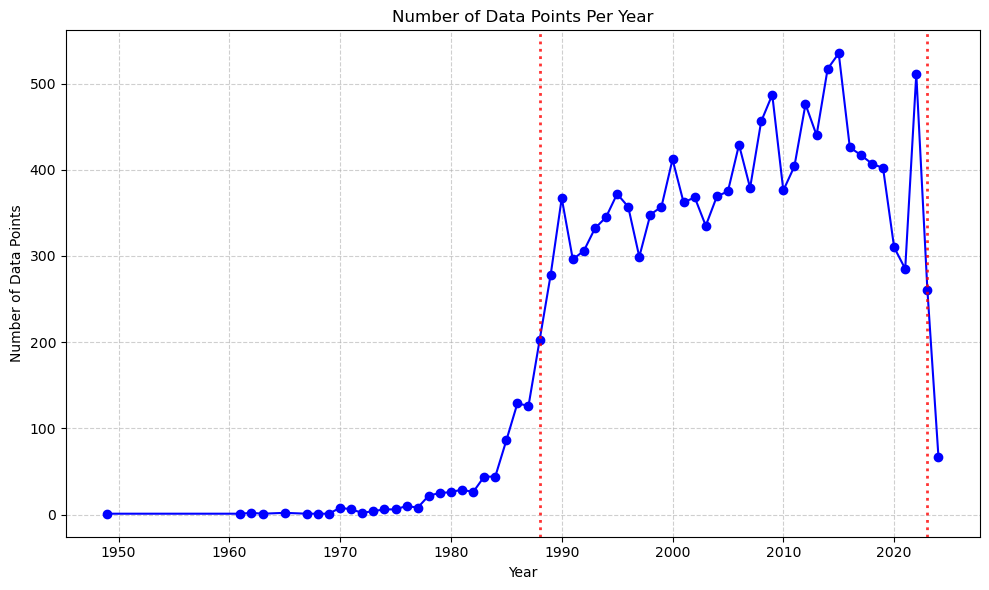

In [9]:

counts = (
    df.groupby('Year of order')
      .size()
      .reset_index(name="n_obs")
      .sort_values('Year of order')

)
counts["se_proxy"] = 1 / np.sqrt(counts["n_obs"])
counts["relative_se"] = (
    counts["se_proxy"] / counts["se_proxy"].min()
)
precision_threshold = 2.0

counts["precise_enough"] = (
    counts["relative_se"] <= precision_threshold
)

precision_year_left = counts.loc[
    counts["precise_enough"], 'Year of order'
].min()

precision_year_right = counts.loc[
    counts["precise_enough"], 'Year of order'
].max()

data_points_per_year = df.groupby('Year of order').size()

# Plot the number of data points per year
plt.figure(figsize=(10, 6))
plt.plot(data_points_per_year.index, data_points_per_year.values, marker='o', linestyle='-', color='blue')
plt.title('Number of Data Points Per Year')
plt.xlabel('Year')
plt.ylabel('Number of Data Points')
plt.grid(True, linestyle='--', alpha=0.6)
plt.axvline(
        x=precision_year_left,
        color='red',
        linestyle=':',
        linewidth=2,
        alpha=0.8
    )
plt.axvline(
        x=precision_year_right,
        color='red',
        linestyle=':',
        linewidth=2,
        alpha=0.8
    )
plt.tight_layout()
plt.savefig('results/data_points_per_year.png', format='png', dpi=300)
plt.show()


df = df[(df['Year of order'] >= precision_year_left) & (df['Year of order'] <= precision_year_right)]



In [10]:
# =========================
# 3. Create Yearly Graphs
# =========================
graphs_by_year = {}
for year, year_df in df.groupby('Year of order'):
    G = nx.DiGraph(year=year)
    for _, row in year_df.iterrows():
        exporter = row['Supplier']
        importer = row['Recipient']
        tiv = row['SIPRI TIV for total order']
        if G.has_edge(exporter, importer):
            G[exporter][importer]['weight'] += tiv
        else:
            G.add_edge(exporter, importer, weight=tiv)
    graphs_by_year[year] = G

# =========================
# 4. Compute Node Features
# =========================
all_features = []
for year, G in graphs_by_year.items():
    for node in G.nodes:
        all_features.append({
            'year': year,
            'country': node,
            'in_degree': G.in_degree(node),
            'out_degree': G.out_degree(node),
            'weighted_in_degree': G.in_degree(node, weight='weight'),
            'weighted_out_degree': G.out_degree(node, weight='weight')
        })

features_df = pd.DataFrame(all_features)

In [11]:
# ===============================
# 5. Build full country–year grid
# ===============================

features_df = (
    features_df
    .set_index(['year', 'country'])
    .reindex(
        pd.MultiIndex.from_product(
            [features_df['year'].unique(),
             features_df['country'].unique()],
            names=['year', 'country']
        )
    )
    .reset_index()
)
# ================================================================
# 6. Rescale years linearly for extra feature in anomaly detection
# ================================================================

features_df['year_scaled'] = MinMaxScaler().fit_transform(features_df[['year']])




In [12]:
# ===================================================================
# 7. Train and fit IsolationForest and LocalOutlierFactor per country
# ===================================================================

feature_cols = [
    'year_scaled',
    'in_degree',
    'out_degree',
    'weighted_in_degree',
    'weighted_out_degree'
]
evaluation_rows = []

features_df['iso_anomaly'] = False
features_df['lof_anomaly'] = False

minimum_data_points = np.round((precision_year_right - precision_year_left) *0.8,0)
print(f"Minimum data points per country: {minimum_data_points}")

for country, df_c in tqdm.tqdm(
    features_df.groupby('country'),
    desc="Processing countries"
):
    df_c = df_c.sort_values('year_scaled')
    df_c = df_c.dropna()
    
    if len(df_c) < minimum_data_points:
        continue

    X = df_c[feature_cols].values
    years = df_c['year'].values

    # ---------------------------
    # Hyperparameter tuning
    # ---------------------------
    best_param_iso = tune_isolation_forest(X)
    best_k = tune_lof(X)

    # ---------------------------
    # Fit models
    # ---------------------------
    iso = IsolationForest(
        n_estimators=best_param_iso[0],
        contamination=best_param_iso[1],
        random_state=42
    )
    iso_labels = iso.fit_predict(X) == -1
    iso_scores = iso.decision_function(X)

    lof = LocalOutlierFactor(n_neighbors=best_k)
    lof_labels = lof.fit_predict(X) == -1

    # ---------------------------
    # Store anomaly flags
    # ---------------------------
    features_df.loc[df_c.index, 'iso_anomaly'] = iso_labels
    features_df.loc[df_c.index, 'lof_anomaly'] = lof_labels

    joint_anomaly = iso_labels & lof_labels

    # ---------------------------
    # Evaluation metrics
    # ---------------------------
    stability = ranking_stability_iforest(X, best_param_iso[1])
    agreement = model_agreement_rate(iso_labels, lof_labels)
    coherence = temporal_coherence(years, joint_anomaly)
    density_gap = density_gap_score(X, joint_anomaly)

    anomaly_rate = joint_anomaly.mean()

    # ---------------------------
    # Append evaluation row
    # ---------------------------
    evaluation_rows.append({
        'country': country,
        'n_years': len(df_c),
        'iso_contamination': best_param_iso[1],
        'lof_k': best_k,
        'anomaly_rate': anomaly_rate,
        'stability_iforest': stability,
        'model_agreement': agreement,
        'temporal_coherence': coherence,
        'density_gap': density_gap
    })
evaluation_df = pd.DataFrame(evaluation_rows)
evaluation_df = evaluation_df.sort_values(
    by='stability_iforest',
    ascending=False
)



Minimum data points per country: 28.0


Processing countries: 100%|██████████| 221/221 [02:35<00:00,  1.42it/s]


In [13]:
####### Nog even goed over nadenken


features_df['anomaly'] = (
    features_df['iso_anomaly'] &
    features_df['lof_anomaly']
)


In [14]:
def plot_country_anomalies(country):
    country_df = (
        features_df[features_df['country'] == country]
        .sort_values('year')
        .set_index('year')
    )
    
    # Full year range to expose missing years
    full_years = np.arange(country_df.index.min(), country_df.index.max() + 1)
    country_full = country_df.reindex(full_years)
    
    # -------------------------------
    # Plot
    # -------------------------------
    fig, (ax1, ax2) = plt.subplots(
        2, 1, figsize=(13, 8), sharex=True
    )
    
    # =========================================================
    # TOP: Weighted volumes
    # =========================================================
    ax1.plot(
        country_full.index,
        country_full['weighted_out_degree'],
        color='blue',
        linewidth=2,
        label='Exports'
    )
    
    ax1.plot(
        country_full.index,
        country_full['weighted_in_degree'],
        color='green',
        linewidth=2,
        label='Imports'
    )
    
    for col, color in [
        ('weighted_out_degree', 'blue'),
        ('weighted_in_degree', 'green')
    ]:
        y = country_full[col]
        valid_idx = np.where(~np.isnan(y.values))[0]
        for i in range(len(valid_idx) - 1):
            idx1, idx2 = valid_idx[i], valid_idx[i + 1]
            if idx2 - idx1 > 1:
                ax1.plot(
                    [y.index[idx1], y.index[idx2]],
                    [y.iloc[idx1], y.iloc[idx2]],
                    color=color,
                    linestyle=':',
                    linewidth=2,
                    alpha=0.8
                )
    
    # -------------------------------
    # Plot anomalies with three colors
    # -------------------------------
    iso_idx = country_full.index[country_full['iso_anomaly'] & ~country_full['lof_anomaly']]
    lof_idx = country_full.index[country_full['lof_anomaly'] & ~country_full['iso_anomaly']]
    joint_idx = country_full.index[country_full['iso_anomaly'] & country_full['lof_anomaly']]
    
    for year in iso_idx:
        ax1.axvline(x=year, color='cyan', linestyle='--', alpha=0.8, label='IF only' if year==iso_idx[0] else "")
    for year in lof_idx:
        ax1.axvline(x=year, color='magenta', linestyle='--', alpha=0.8, label='LOF only' if year==lof_idx[0] else "")
    for year in joint_idx:
        ax1.axvline(x=year, color='red', linestyle='-', linewidth=2, alpha=0.8, label='Overlap' if year==joint_idx[0] else "")
    
    ax1.set_ylabel('Weighted Arms Transfers (TIV)')
    ax1.set_title(f'{country} Arms Transfers: Volume')
    ax1.set_xlabel('Year')
    ax1.tick_params(axis='x', labelbottom=True)
    
    # =========================================================
    # BOTTOM: Connectivity (degrees)
    # =========================================================
    ax2.plot(
        country_full.index,
        country_full['out_degree'],
        color='blue',
        linewidth=2,

    )
    
    ax2.plot(
        country_full.index,
        country_full['in_degree'],
        color='green',
        linewidth=2,

    )
    
    for col, color in [
        ('out_degree', 'blue'),
        ('in_degree', 'green')
    ]:
        y = country_full[col]
        valid_idx = np.where(~np.isnan(y.values))[0]
        for i in range(len(valid_idx) - 1):
            idx1, idx2 = valid_idx[i], valid_idx[i + 1]
            if idx2 - idx1 > 1:
                ax2.plot(
                    [y.index[idx1], y.index[idx2]],
                    [y.iloc[idx1], y.iloc[idx2]],
                    color=color,
                    linestyle=':',
                    linewidth=2,
                    alpha=0.8
                )
    
    # -------------------------------
    # Plot anomalies for connectivity with same colors
    # -------------------------------
    for year in iso_idx:
        ax2.axvline(x=year, color='cyan', linestyle='--', alpha=0.8)
    for year in lof_idx:
        ax2.axvline(x=year, color='magenta', linestyle='--', alpha=0.8)
    for year in joint_idx:
        ax2.axvline(x=year, color='red', linestyle='-', linewidth=2, alpha=0.8)
    
    ax2.set_ylabel('Number of Trade Partners')
    ax2.set_xlabel('Year')
    ax2.set_title(f'{country} Arms Transfers: Network Connectivity')
    
    # =========================================================
    # Legend (shared)
    # =========================================================
    missing_line = mlines.Line2D(
        [], [], color='black', linestyle=':', linewidth=2,
        label='Missing Years (Interpolated)'
    )
    
    handles1, labels1 = ax1.get_legend_handles_labels()
    handles2, labels2 = ax2.get_legend_handles_labels()
    
    # Add custom anomaly lines to legend
    handles = handles1 + handles2 
    labels = [h.get_label() for h in handles]
    
    fig.legend(
        handles=handles,
        labels=labels,
        loc='upper center',
        ncol=4,
        frameon=False
    )
    
    ax1.grid(True, linestyle='--', alpha=0.6)
    ax2.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout(rect=[0, 0, 1, 0.93])
    plt.savefig(f'results/{country}_anomalies.png')
    plt.show()


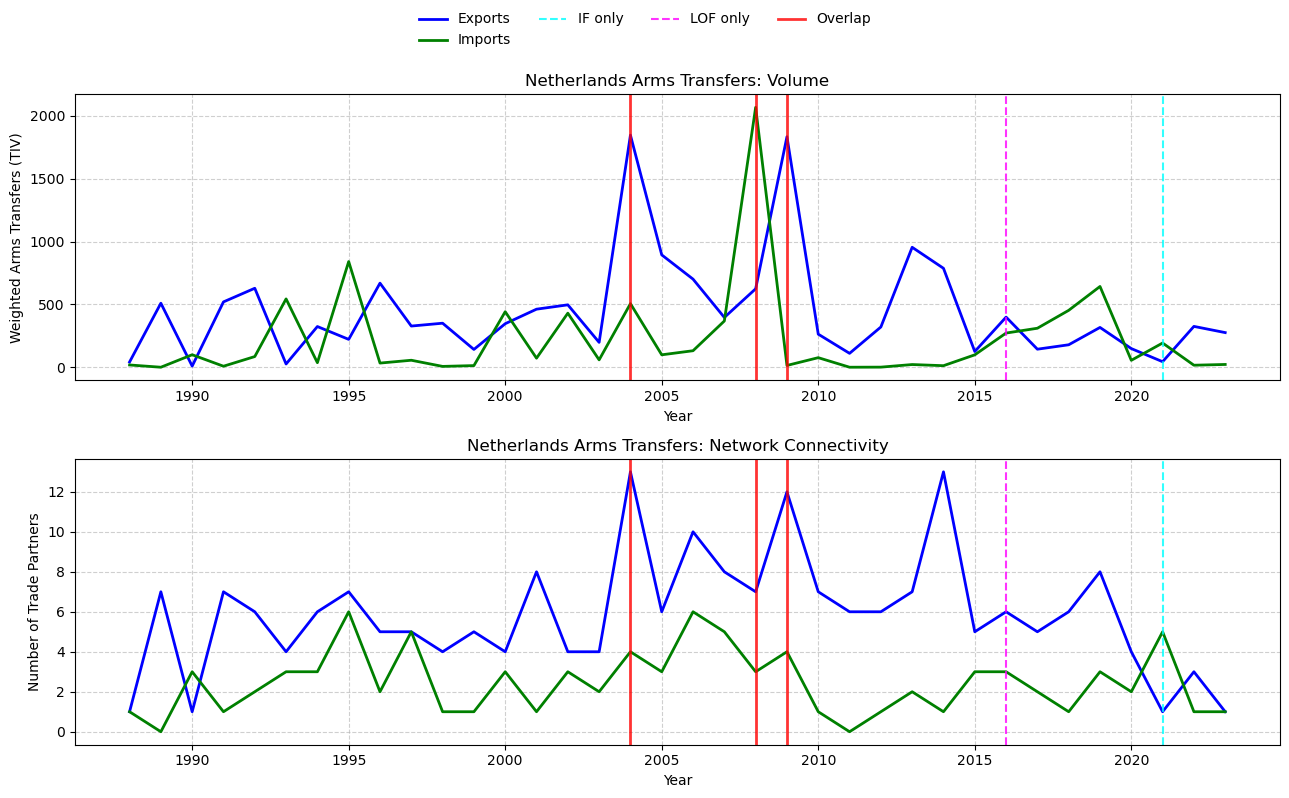

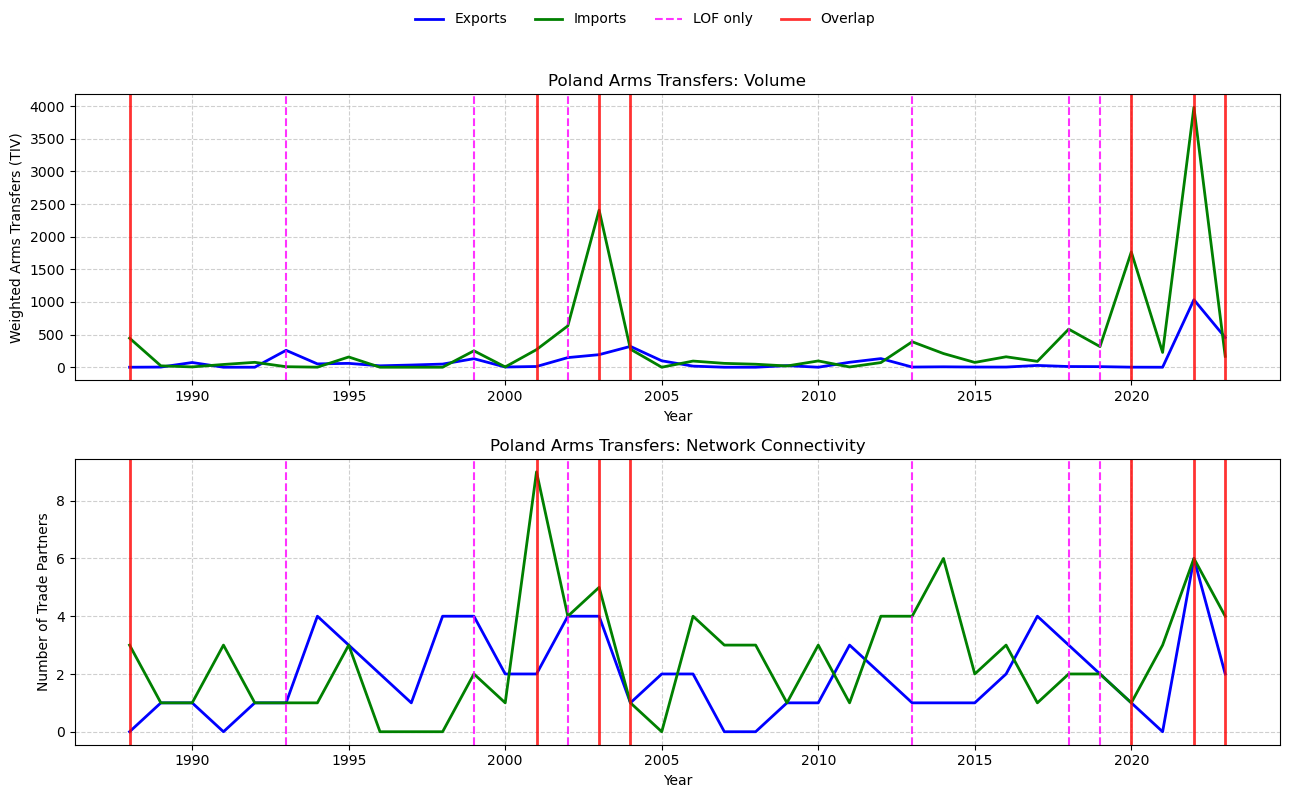

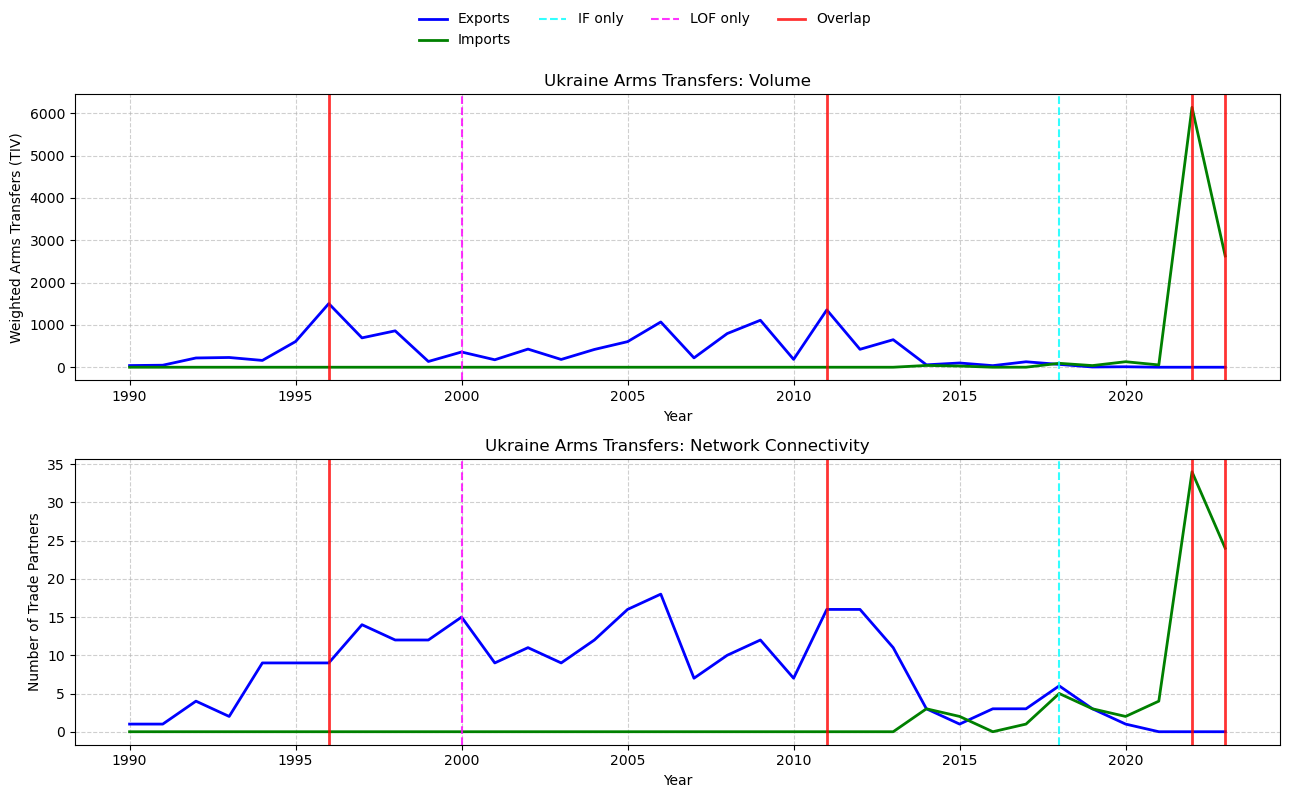

In [27]:
countries = ['Netherlands','Poland','Ukraine']

for country in countries:
    plot_country_anomalies(country)

In [16]:
RELIABILITY_THRESHOLDS = {
    'min_stability': 0.8,
    'min_agreement': 0.7,
    'max_anomaly_rate': 0.2,
    'min_density_gap': 0.000000000001,   # anomalies must be lower density
    'min_years': 20
}
evaluation_df['unreliable'] = (
    (evaluation_df['stability_iforest'] < RELIABILITY_THRESHOLDS['min_stability']) |
    (evaluation_df['model_agreement'] < RELIABILITY_THRESHOLDS['min_agreement']) |
    (evaluation_df['anomaly_rate'] > RELIABILITY_THRESHOLDS['max_anomaly_rate']) |
    (evaluation_df['density_gap'] >= RELIABILITY_THRESHOLDS['min_density_gap']) |
    (evaluation_df['n_years'] < RELIABILITY_THRESHOLDS['min_years'])
)
unreliable_countries = (
    evaluation_df
    .loc[evaluation_df['unreliable'], [
        'country',
        'n_years',
        'stability_iforest',
        'model_agreement',
        'anomaly_rate',
        'density_gap'
    ]]
    .sort_values('stability_iforest')
)

print("Countries with unreliable anomaly detection:")
display(unreliable_countries)


def unreliability_reason(row):
    reasons = []
    if row['stability_iforest'] < RELIABILITY_THRESHOLDS['min_stability']:
        reasons.append('low_stability')
    if row['model_agreement'] < RELIABILITY_THRESHOLDS['min_agreement']:
        reasons.append('low_agreement')
    if row['anomaly_rate'] > RELIABILITY_THRESHOLDS['max_anomaly_rate']:
        reasons.append('too_many_anomalies')
    if row['density_gap'] >= RELIABILITY_THRESHOLDS['min_density_gap']:
        reasons.append('no_density_separation')
    if row['n_years'] < RELIABILITY_THRESHOLDS['min_years']:
        reasons.append('short_time_series')
    return ', '.join(reasons)


evaluation_df['unreliability_reason'] = (
    evaluation_df
    .apply(unreliability_reason, axis=1)
)


Countries with unreliable anomaly detection:


,country,n_years,stability_iforest,model_agreement,anomaly_rate,density_gap
48,Slovakia,28,0.955802,0.571429,0.107143,-0.021456
50,South Korea,36,0.956564,0.694444,0.055556,0.000000
12,Chile,36,0.959717,0.694444,0.027778,-0.000366
32,Malaysia,33,0.969753,0.696970,0.030303,-0.001933
34,Morocco,31,0.969758,0.645161,0.129032,-0.009416
7,Belarus,29,0.975246,0.620690,0.068966,-0.058786
25,Indonesia,35,0.976190,0.685714,0.085714,-0.023953
43,Portugal,28,0.976601,0.392857,0.107143,-0.076591
18,Egypt,36,0.976705,0.694444,0.111111,0.000000
29,Japan,33,0.978777,0.696970,0.030303,-0.000151


In [17]:
evaluation_df['unreliability_reason'].value_counts()

unreliability_reason
                 53
low_agreement    12
Name: count, dtype: int64

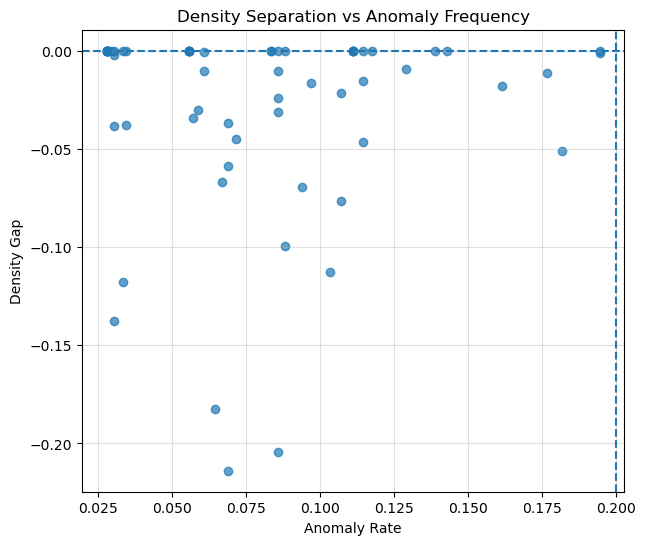

In [19]:
plt.figure(figsize=(7, 6))
plt.scatter(
    evaluation_df['anomaly_rate'],
    evaluation_df['density_gap'],
    alpha=0.7
)

plt.axhline(0, linestyle='--')
plt.axvline(RELIABILITY_THRESHOLDS['max_anomaly_rate'], linestyle='--')

plt.xlabel('Anomaly Rate')
plt.ylabel('Density Gap')
plt.title('Density Separation vs Anomaly Frequency')
plt.grid(alpha=0.4)
plt.show()


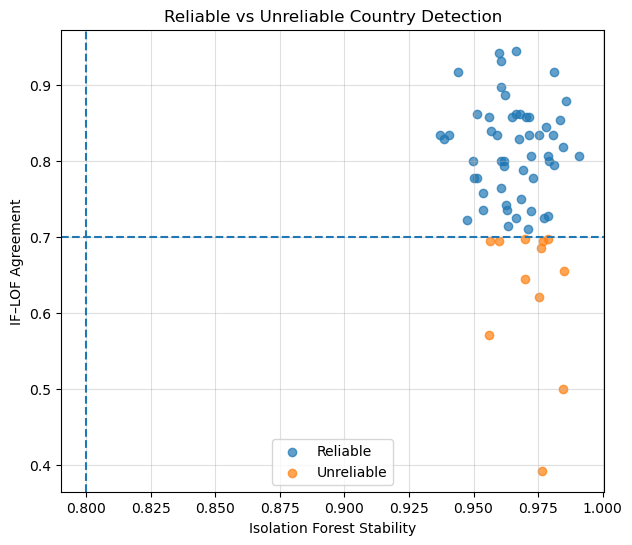

In [20]:
plt.figure(figsize=(7, 6))

reliable = evaluation_df[~evaluation_df['unreliable']]
unreliable = evaluation_df[evaluation_df['unreliable']]

plt.scatter(
    reliable['stability_iforest'],
    reliable['model_agreement'],
    label='Reliable',
    alpha=0.7
)

plt.scatter(
    unreliable['stability_iforest'],
    unreliable['model_agreement'],
    label='Unreliable',
    alpha=0.7
)

plt.axvline(RELIABILITY_THRESHOLDS['min_stability'], linestyle='--')
plt.axhline(RELIABILITY_THRESHOLDS['min_agreement'], linestyle='--')

plt.xlabel('Isolation Forest Stability')
plt.ylabel('IF–LOF Agreement')
plt.legend()
plt.grid(alpha=0.4)
plt.title('Reliable vs Unreliable Country Detection')
plt.show()


In [21]:
evaluation_df['reliability_score'] = (
    evaluation_df['stability_iforest'] *
    evaluation_df['model_agreement'] *
    (1 - evaluation_df['anomaly_rate'])
)

evaluation_df = evaluation_df.sort_values(
    by='reliability_score',
    ascending=True
)


evaluation_df[['country', 'reliability_score']]


,country,reliability_score
43,Portugal,0.342558
23,Hungary,0.475968
48,Slovakia,0.487654
34,Morocco,0.544921
8,Belgium,0.551166
...,...,...
62,Uruguay,0.832665
36,Netherlands,0.836548
44,Romania,0.840196
21,Germany,0.841425
